In [113]:
import os

from dotenv import load_dotenv
load_dotenv()
OPEN_API_KEY = os.getenv("OPENAI_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")



In [56]:
#Extract data
from unstructured.partition.pdf import partition_pdf

output_path = "./content/"
file_path = 'attention.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
   
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image","Table"],   # Add 'Table' to list to extract image of tables
    #image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

In [57]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.
print(len(chunks))
set([str(type(el)) for el in chunks])
for chunk in chunks:
    print(chunk.metadata.orig_elements)

9
[<unstructured.documents.elements.Title object at 0x0000022AB6A7F310>, <unstructured.documents.elements.NarrativeText object at 0x0000022AB6A7F460>, <unstructured.documents.elements.NarrativeText object at 0x0000022AB6A7F620>, <unstructured.documents.elements.Title object at 0x0000022AB6BE2A50>, <unstructured.documents.elements.NarrativeText object at 0x0000022AB6A7F690>, <unstructured.documents.elements.NarrativeText object at 0x0000022AB6A7F230>, <unstructured.documents.elements.NarrativeText object at 0x0000022AB6A7F770>, <unstructured.documents.elements.NarrativeText object at 0x0000022AB6A7F850>, <unstructured.documents.elements.NarrativeText object at 0x0000022AB6A7F930>, <unstructured.documents.elements.Title object at 0x0000022AB6A7FA10>, <unstructured.documents.elements.NarrativeText object at 0x0000022AB6A7FAF0>, <unstructured.documents.elements.Title object at 0x0000022AB6A7FBD0>, <unstructured.documents.elements.NarrativeText object at 0x0000022AB6A7FCB0>, <unstructured.d

In [58]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()




{'type': 'Image',
 'element_id': 'da3fb822-a782-4183-8e2a-c63c64331de9',
 'text': '',
 'metadata': {'coordinates': {'points': ((np.float64(486.0),
     np.float64(261.1805555555558)),
    (np.float64(486.0), np.float64(614.7805555555556)),
    (np.float64(664.0), np.float64(614.7805555555556)),
    (np.float64(664.0), np.float64(261.1805555555558))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-06-07T12:39:51',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 4,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFiALIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJ

In [109]:
# separate tables from texts
tables = []
texts = []
texts_c = []
elements1=[]
image_c=[]

for chunk in chunks:
    if "CompositeElement" in str(type((chunk))):
        texts_c.append(chunk)
    elements = chunk.metadata.orig_elements
    for element in elements:
        elements1.append(element.category)
        #print(element.category)
        if (element.category == 'Table'):
            tables.append(chunk)
        elif(element.category != 'Image' and  element.category != 'Table'):
            texts.append(chunk)
        

    

In [94]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

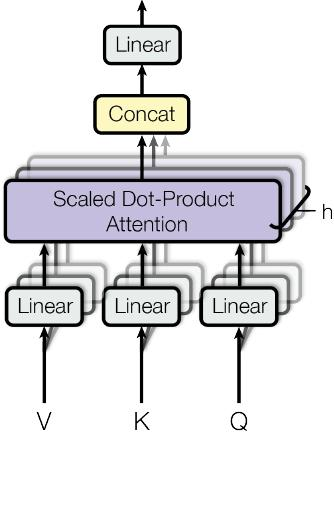

In [103]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[2])

In [100]:
tables[0].to_dict()

{'type': 'CompositeElement',
 'element_id': 'd0c135ce9138d50900d8097fa16c6a69',
 'text': '3.5 Positional Encoding\n\nSince our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the\n\n5\n\nTable 1: Maximum path lengths, per-layer complexity and minimum number of sequential operations for different layer types. n is the sequence length, d is the representation dimension, k is the kernel size of convolutions and r the size of the neighborhood in restricted self-attention.\n\nLayer Type Complexity per Layer Sequential Maximum Path Length Operations Self-Attention O(n2 · d) O(1) O(1) Recurrent O(n · d2) O(n) O(n) Convolutional O(k · n · d2) O(1) O(logk(n)) Self-Attention (restricted) O(r · n · d) O(1) O(n/r)\n\nbottoms of the encoder and decoder stacks. The

In [106]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()




In [107]:
image_summaries = chain.batch(images)

The image depicts a detailed schematic of the transformer architecture, a foundational model in natural language processing.

### Key Components:
1. **Inputs and Outputs**:
   - **Input Embedding**: Located at the bottom left, it represents the input sequence.
   - **Output Embedding**: Positioned at the bottom right, indicative of the shift to the right for decoding.

2. **Positional Encoding**:
   - Found at the bottom, it connects the input and output embeddings to the rest of the model, suggesting the incorporation of positional information in the sequence.

3. **Layers**:
   - The structure contains two main sections, indicative of the encoder (left) and decoder (right), both consisting of several identical blocks (labeled Nx for layers).
   - Each block in the encoder consists of:
     - **Multi-Head Attention**: Focuses on various parts of the input simultaneously.
     - **Add & Norm**: A residual connection followed by layer normalization.
     - **Feed Forward**: A fully conn

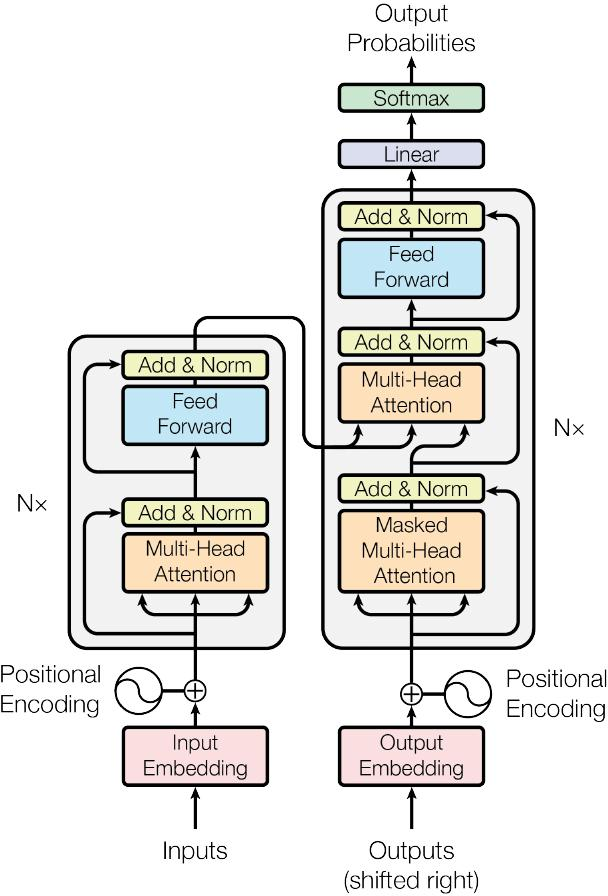

In [130]:
print(image_summaries[0])

display_base64_image(images[0])

In [122]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="llama-3.3-70b-versatile")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [124]:
# Summarize text
#text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})


In [120]:
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [121]:
table_summaries

['The table compares four neural network layer types: Self-Attention, Recurrent, Convolutional, and Self-Attention (restricted). \nSelf-Attention has O(n^2 - d) complexity, O(1) sequential operations, and O(1) maximum path length.\nRecurrent has O(n-d) complexity, O(n) sequential operations, and O(n) maximum path length.\nConvolutional has O(k-n-d) complexity, only sequential operations, and O(log(n)) maximum path length.\nSelf-Attention (restricted) has O(r-n-d) complexity, few sequential operations, and O(n/r) maximum path length.',
 'The table compares various machine translation models, including ByteNet, Deep-Att, GNMT, ConvS2S, MoE, and Transformer models, across different metrics such as EN-DE translation quality, BLEU EN-FR score, and training and cost (FLOPs) for EN-FR translation. The Transformer (big) model achieves the highest EN-DE translation quality score of 28.4, while the GNMT + RL Ensemble model achieves the highest BLEU EN-FR score of 41.16.',
 'The table compares va

In [125]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()

# Summary chain
model = ChatOpenAI(temperature=0.5,model="gpt-4o-mini") 
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [126]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

In [127]:
text_summaries

['The paper introduces the Transformer, a novel neural network architecture that relies solely on attention mechanisms, eliminating the need for recurrent or convolutional structures. This model outperforms traditional sequence transduction models in machine translation tasks, achieving a BLEU score of 28.4 for English-to-German and 41.0 for English-to-French translations, representing significant improvements over previous state-of-the-art results. The Transformer allows for greater parallelization and faster training times, demonstrating its efficiency in handling longer sequences without the limitations of sequential computation.',
 'The paper introduces the Transformer, a novel neural network architecture that relies solely on attention mechanisms, eliminating the need for recurrent or convolutional structures. This approach enhances parallelization and training efficiency, achieving superior results in machine translation tasks. Specifically, the Transformer reached a BLEU score o

In [134]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [135]:
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

In [140]:
docs = retriever.invoke(
    "what is multi head attention?"
)
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

3.2.1 Scaled Dot-Product Attention

We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of queries and keys of dimension dk, and values of dimension dv. We compute the dot products of the

3

Scaled Dot-Product Attention

Multi-Head Attention

Linear

Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several attention layers running in parallel.

√

query with all keys, divide each by dk, and apply a softmax function to obtain the weights on the values.

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices K and V . We compute the matrix of outputs as:

Attention(Q,K,V ) = softmax( QKT √ dk )V (1)

The two most commonly used attention functions are additive attention [2], and dot-product (multi- plicative) attention. Dot-product attention is identical to our algorithm, except for the sc

In [141]:
#RAG PipleLine
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode

In [144]:
def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}

def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )

chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)




In [145]:
response = chain.invoke(
    "What is the attention mechanism?"
)


In [ ]:
print(response)

589

In [157]:
response = chain_with_sources.invoke(
    "What is the attention mechanism?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

Response: The attention mechanism is a technique in neural networks that allows the model to focus on specific parts of the input sequence when producing an output. It enables the model to draw dependencies between input and output elements without regard to their distance in the sequence. This means that the model can attend to different parts of the input when generating each element of the output, effectively capturing relationships that may not be sequentially close. In the context of the Transformer architecture, attention is used without recurrence or convolutions, allowing for more parallelization and improved computational efficiency.


Context:
Attention Is All You Need

Ashish Vaswani∗ Google Brain avaswani@google.com

Noam Shazeer∗ Google Brain noam@google.com

Niki Parmar∗

Google Research nikip@google.com

Jakob Uszkoreit∗ Google Research usz@google.com

Llion Jones∗ Google Research llion@google.com

Aidan N. Gomez∗ † University of Toronto aidan@cs.toronto.edu

Łukasz Kais

In [156]:
response

{'context': {'images': [],
  'texts': [<unstructured.documents.elements.CompositeElement at 0x22ab6be20b0>,
   <unstructured.documents.elements.CompositeElement at 0x22ab6be20b0>]},
 'question': 'What is multihead?',
 'response': 'Multi-head attention is a mechanism that consists of multiple parallel attention layers (or heads) that allow a model to jointly attend to information from different representation subspaces at various positions. Instead of performing a single attention function with dimensional keys, values, and queries, the queries, keys, and values are linearly projected multiple times (h times), producing different representations. Each projected version undergoes the attention function in parallel, resulting in output values that are then concatenated and projected again to yield the final output. This approach enables the model to capture a broader spectrum of relationships and complexities in the input data. In the context provided, 8 parallel attention layers are used

In [158]:
response = chain.invoke(
    "What is the Maximum Path Length for Self-Attention  Layer Type?"
)

print(response)

The Maximum Path Length for the Self-Attention Layer Type is O(1).


In [159]:
response

'The Maximum Path Length for the Self-Attention Layer Type is O(1).'

In [160]:
response = chain.invoke(
    "What is the next step after SoftMax in Scaled Dot-Product Attention?"
)

In [163]:
print(response)

After applying the SoftMax function in Scaled Dot-Product Attention, the next step is to use the resulting weights to compute a weighted sum of the values. Specifically, you multiply the SoftMax output by the matrix of values \( V \) to obtain the final output of the attention mechanism. The formula for this step is:

\[
\text{Attention}(Q,K,V) = \text{SoftMax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\]
